In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import GPy
import pickle

plt.style.use('hfs')

def sampled_LC_params(m, t, alpha=0.01, ax1 = None, ax2 = None, ax3 = None, size=100):
    
    _mag_interp, sigma = m.predict(t, full_cov=True)
    _mag_interp=_mag_interp[:,0]*-1
    _time_interp = t[:,0]

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]

    ax1.plot(_time_interp, _mag_interp*-1, c='k', label='GP', alpha=alpha, zorder=10000)
    
    
    x_30_40 = np.atleast_2d(np.array([30, 40])).T
    mag_30_40, __ = m.predict(x_30_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_30_40[1]-mag_30_40[0])
    ax1.axvline(_time_interp[_ind_tmax],c='grey', lw=1, alpha=alpha, label='t$_{max}$')
    ax1.axvline(x_30_40[0],c='k', ls=':', alpha=0.5, label='+30 days')
    ax1.axvline(x_30_40[1],c='k', ls=':', alpha=0.8, label='+40 days')

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':', alpha=alpha, label='dm1')

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--',  alpha=alpha, label='dm2')
    
    ## Sampling to show uncertianties
    test = np.random.multivariate_normal(_mag_interp,  sigma, size=size)
    for i in range(test.shape[0]):
        _v_i = test[i,:]
        ax1.plot(_time_interp , _v_i*-1, alpha=0.01, zorder=0.1, color='k')
        _grad1 = np.gradient(_v_i)
        ax2.plot(_time_interp, _grad1, color='r', alpha=0.01)
        _grad2 = np.gradient(_grad1)
        ax3.plot(_time_interp, _grad2, color='b', alpha=0.01)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]


In [20]:
data_IIb = pd.read_csv('../Data/IIb_clean_sample.dat', index_col=0)
data_II = pd.read_csv('../Data/II_clean_sample.dat', index_col=0)

In [21]:
data_II=data_II[data_II.event!='SN1992ba']
data_II=data_II[~((data_II.source=='2014MNRAS.442..844F') & (data_II.event=='SN1999em'))] # for 99em (see notebook)
data_II=data_II[~((data_II.source=='2019MNRAS.490.2799D,2012MNRAS.425.1789S') & (data_II.event=='SN2012aw'))]  #(for 12aw)
data_IIb=data_IIb[data_IIb.event!='SN2004ex']

In [22]:
data_II

,event,MJD,V,source,texp,texp_source,Verr
0,SN2013ej,56498.309,14.490,2016MNRAS.461.2003Y,56497.5,Pessi+19 T.A1,0.07
1,SN2013ej,56500.840,12.980,2016MNRAS.461.2003Y,56497.5,Pessi+19 T.A1,0.03
2,SN2013ej,56500.897,12.980,2016MNRAS.461.2003Y,56497.5,Pessi+19 T.A1,0.00
3,SN2013ej,56501.256,12.910,2016MNRAS.461.2003Y,56497.5,Pessi+19 T.A1,0.00
4,SN2013ej,56501.840,12.870,2016MNRAS.461.2003Y,56497.5,Pessi+19 T.A1,0.04
...,...,...,...,...,...,...,...
1275,SN2013ai,56432.695,18.546,2016MNRAS.459.3939V,56339.7,Pessi+19 T.A1,0.20
1276,SN2013ai,56432.697,18.404,2016MNRAS.459.3939V,56339.7,Pessi+19 T.A1,0.20
1277,SN2013ai,56432.951,18.545,2016MNRAS.459.3939V,56339.7,Pessi+19 T.A1,0.00
1278,SN2013ai,56434.953,18.541,2016MNRAS.459.3939V,56339.7,Pessi+19 T.A1,0.20


In [23]:
SN_names = np.array(list(data_IIb.event.unique())+list(data_II.event.unique()))
SN_names = SN_names.reshape(4,5)

SN2008ax
SN2011dh
SN1993J
SN2006T
SN2008aq
SN2013df
SN2006el
SN2013ej
SN2012aw
SN1999em
SN2014cx
SN2004er
SN2009ib
SN2013fs
SN2009N
SN2014G
SN2003hn
SN2008aw
SN1999gi
SN2013ai


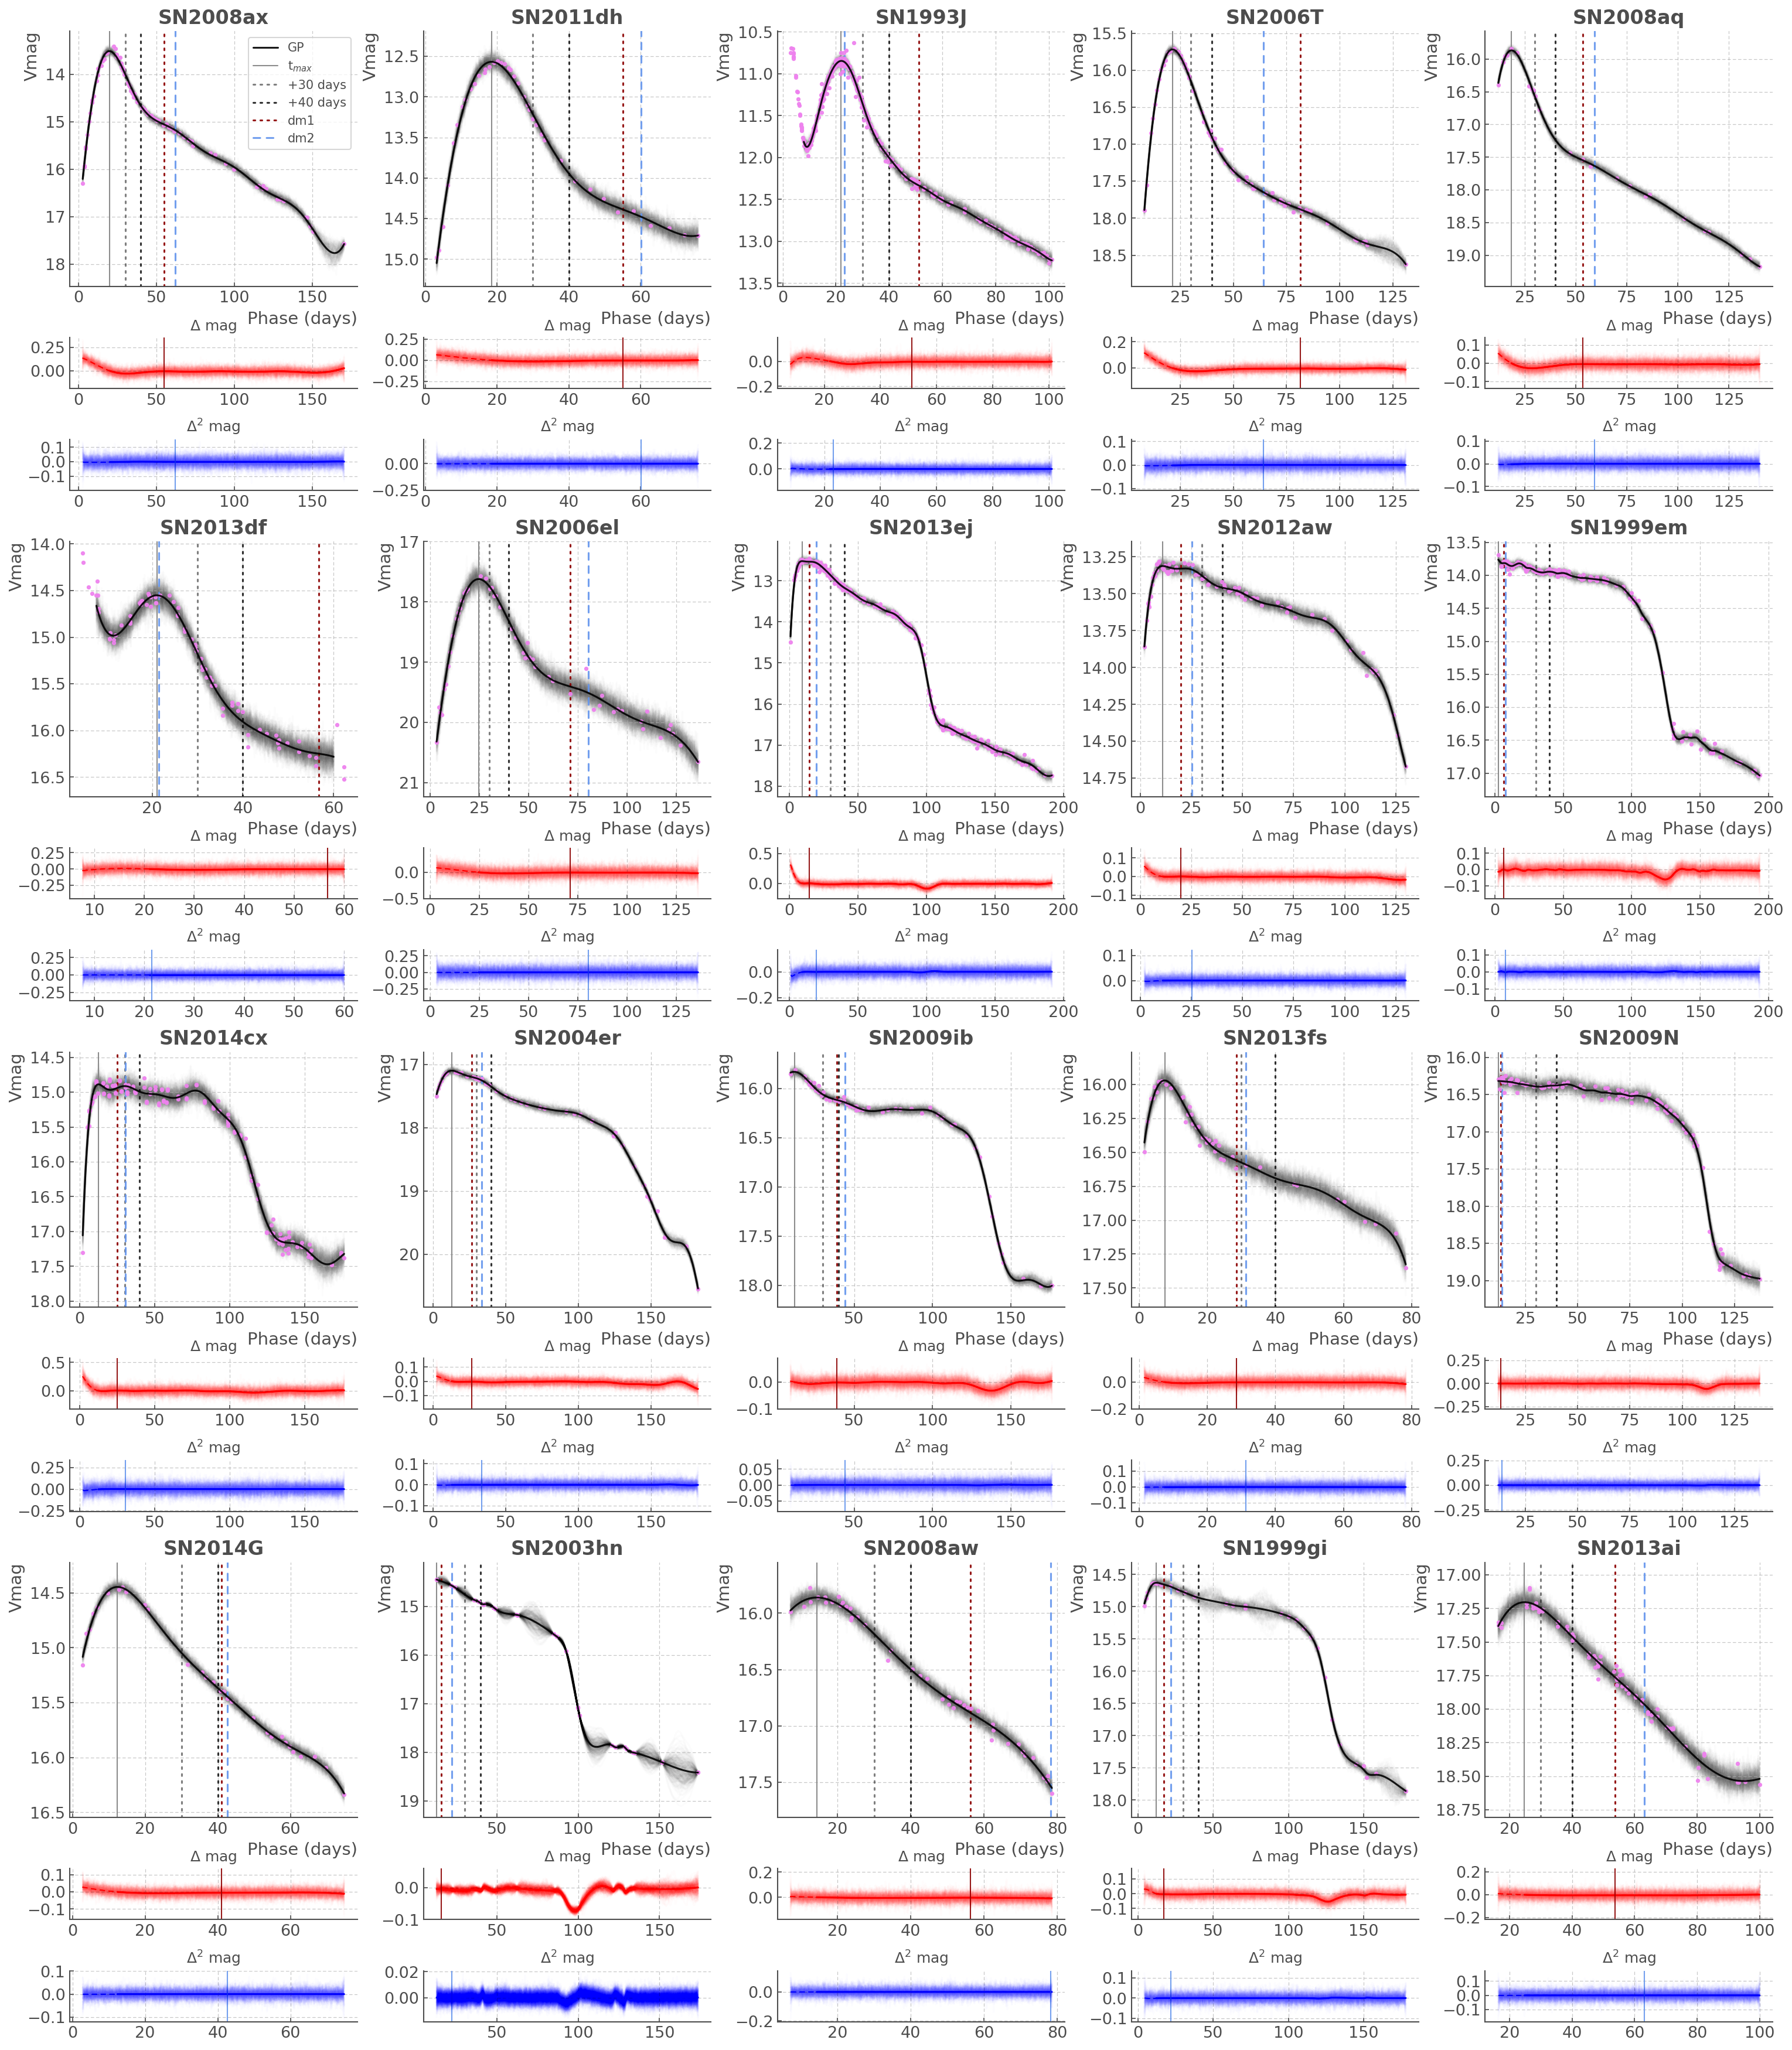

In [24]:
fig = plt.figure(figsize=(25,30))
gs = GridSpec(20,20, hspace=1, wspace=3)

for j in range(0,4):
    for i in range(0,5):
        _sn = SN_names[j,i]
        print(_sn)
        _axLC = fig.add_subplot(gs[j*5:j*5+3, i*4:i*4+4])
        _axdm1 = fig.add_subplot(gs[j*5+3,i*4:i*4+4])
        _axdm2 = fig.add_subplot(gs[j*5+4,i*4:i*4+4])

        _file = open(f'{_sn}.gpym', 'rb')
        _m = pickle.load(_file)
        

        try:
            data = data_IIb[data_IIb.event==_sn]
            phase = data.MJD.values - data.texp.iloc[0]
        except IndexError:
            data = data_II[data_II.event==_sn]
            phase = data.MJD.values - data.texp.iloc[0]   
        
        t = np.atleast_2d(np.linspace(phase.min(), phase.max(),400)).T
        
        if _sn == 'SN1993J':
            t = np.atleast_2d(np.linspace(phase.min()+5, phase.max(),400)).T
        if _sn == 'SN2013df':
            t = np.atleast_2d(np.linspace(phase.min()+3, 60,400)).T
            
        size=75
        if np.isin(_sn, ['SN2003hn', 'SN1999ig']): size=250
        
        sampled_LC_params(_m, t, alpha=0.9, 
                          ax1=_axLC, ax2=_axdm1, ax3=_axdm2, size=size)
        
        _axLC.scatter(phase, data.V.values, c='violet', alpha=0.9, zorder=100)
        _axLC.invert_yaxis()
        
        _axLC.set_ylabel("Vmag",
                          loc="top")
        _axLC.set_xlabel("Phase (days)",
                          loc="right")
        
        if i==0 and j ==0:
            _axLC.legend(ncol=1)
            
        _axLC.set_title(f'{_sn}', fontweight ='bold', fontsize=16)
        _axdm1.set_title('$\Delta$ mag', 
                          fontsize=12)
        _axdm2.set_title('$\Delta^2$ mag',  
                          fontsize=12)
        _file.close()
        
plt.savefig('all_fits.png', dpi=200, bbox_inches='tight')